# California House Price Prediction

This project is an end-to-end machine learning solution for predicting housing prices in California. The application is built using FastAPI for serving the machine learning model and Docker for containerization, ensuring easy deployment and scalability.

## [Data](#data)
- ### Exploratory Data Analysis
    - ### Summary Statistics
    - ### Data Visualization
- ### Missing Value Check
- ### Outlier Check
- ### Multicollinearity

## [Modeling](#modeling)
- ### Data Preparation
- ### Cross Validation
- ### Best Model
- ### Model Evaluation
- ### Feature Importance

## [Serialization](#serialization)
- ### Serialization
- ### Deserialization
- ### New Predictions

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler,FunctionTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures,StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# from utils import add_features
# import folium
# from folium.plugins import MarkerCluster

## Data<a id='data'></a>

In [2]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Exploratory Data Analysis (EDA)

Let's take a look at how much data there is. We'll also take a look at the columns as a starting place to see what data has been collected

In [3]:
print(data.shape)
cols = data.columns
print(cols)

(20640, 10)
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


There are more than 20,000 individual housing groups/tracts that were included in this dataset. 

In [4]:
data.describe().round()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.0,20640.0,20640.0,20640.0,20433.0,20640.0,20640.0,20640.0,20640.0
mean,-120.0,36.0,29.0,2636.0,538.0,1425.0,500.0,4.0,206856.0
std,2.0,2.0,13.0,2182.0,421.0,1132.0,382.0,2.0,115396.0
min,-124.0,33.0,1.0,2.0,1.0,3.0,1.0,0.0,14999.0
25%,-122.0,34.0,18.0,1448.0,296.0,787.0,280.0,3.0,119600.0
50%,-118.0,34.0,29.0,2127.0,435.0,1166.0,409.0,4.0,179700.0
75%,-118.0,38.0,37.0,3148.0,647.0,1725.0,605.0,5.0,264725.0
max,-114.0,42.0,52.0,39320.0,6445.0,35682.0,6082.0,15.0,500001.0


In [5]:
# Identify Categorical/Numerical Features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Most of the data is in numeric form, all but `ocean_proximity`, so we'll look at how to deal with that. To start, however, let's plot the distributions (histograms) of all values to see how the numeric values are distributed.

### Geo Features
Looks like we've got some geographic identification in the form of latitude-longitude coordinates. We can use folium to visualize the extent of the data-- perhaps it isn't statewide. At the very least, we can see where the sampled housing sets are located.

In [7]:
# # Create a map centered on California
# california_coords = [36.7783, -119.4179]
# m = folium.Map(location=california_coords, zoom_start=6)

# # Create a MarkerCluster
# marker_cluster = MarkerCluster().add_to(m)

# # Sample the data if it's too large (optional)
# # housing_data = housing_data.sample(n=1000)

# # Add points to the map
# for idx, row in data.iterrows():
#     folium.CircleMarker(
#         location=[row['latitude'], row['longitude']],
#         radius=5,
#         popup=f"Median House Value: ${row['median_house_value']:,.0f}",
#         color='#3186cc',
#         fill=True,
#         fill_color='#3186cc'
#     ).add_to(marker_cluster)
    
# # display(m)

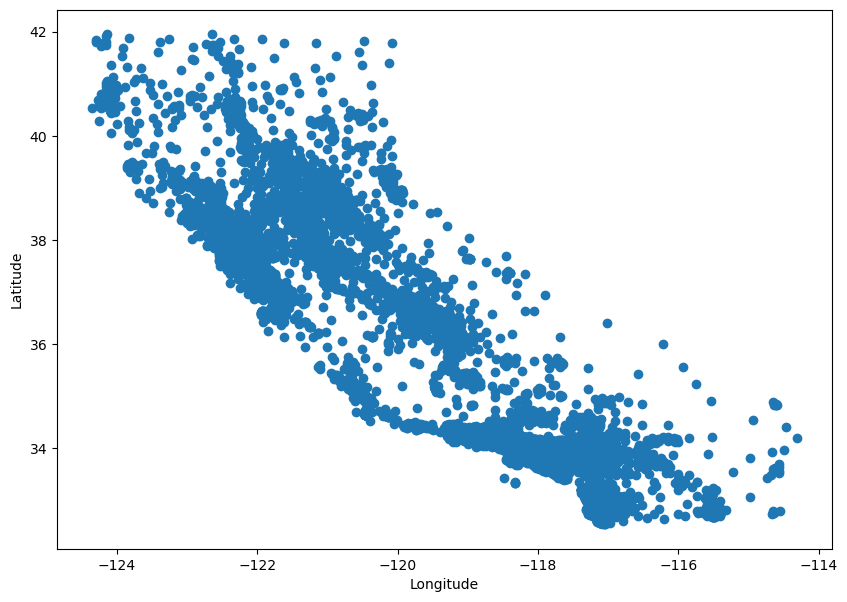

In [8]:
plt.figure(figsize=(10,7))
plt.scatter(data['longitude'], data['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Categorical Features

In [9]:
# Distribution of Categorical Features
data['ocean_proximity'].value_counts(normalize=True)

ocean_proximity
<1H OCEAN     0.442636
INLAND        0.317393
NEAR OCEAN    0.128779
NEAR BAY      0.110950
ISLAND        0.000242
Name: proportion, dtype: float64

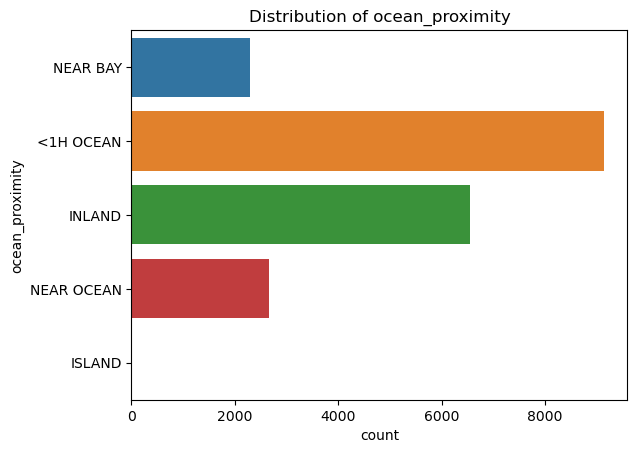

In [10]:
sns.countplot(y='ocean_proximity', data=data)
plt.title('Distribution of ocean_proximity')
plt.show()

Most of the housing groups are `<1H OCEAN` or `INLAND`, with a very small sample loated in`ISLAND`

### Numerical Features

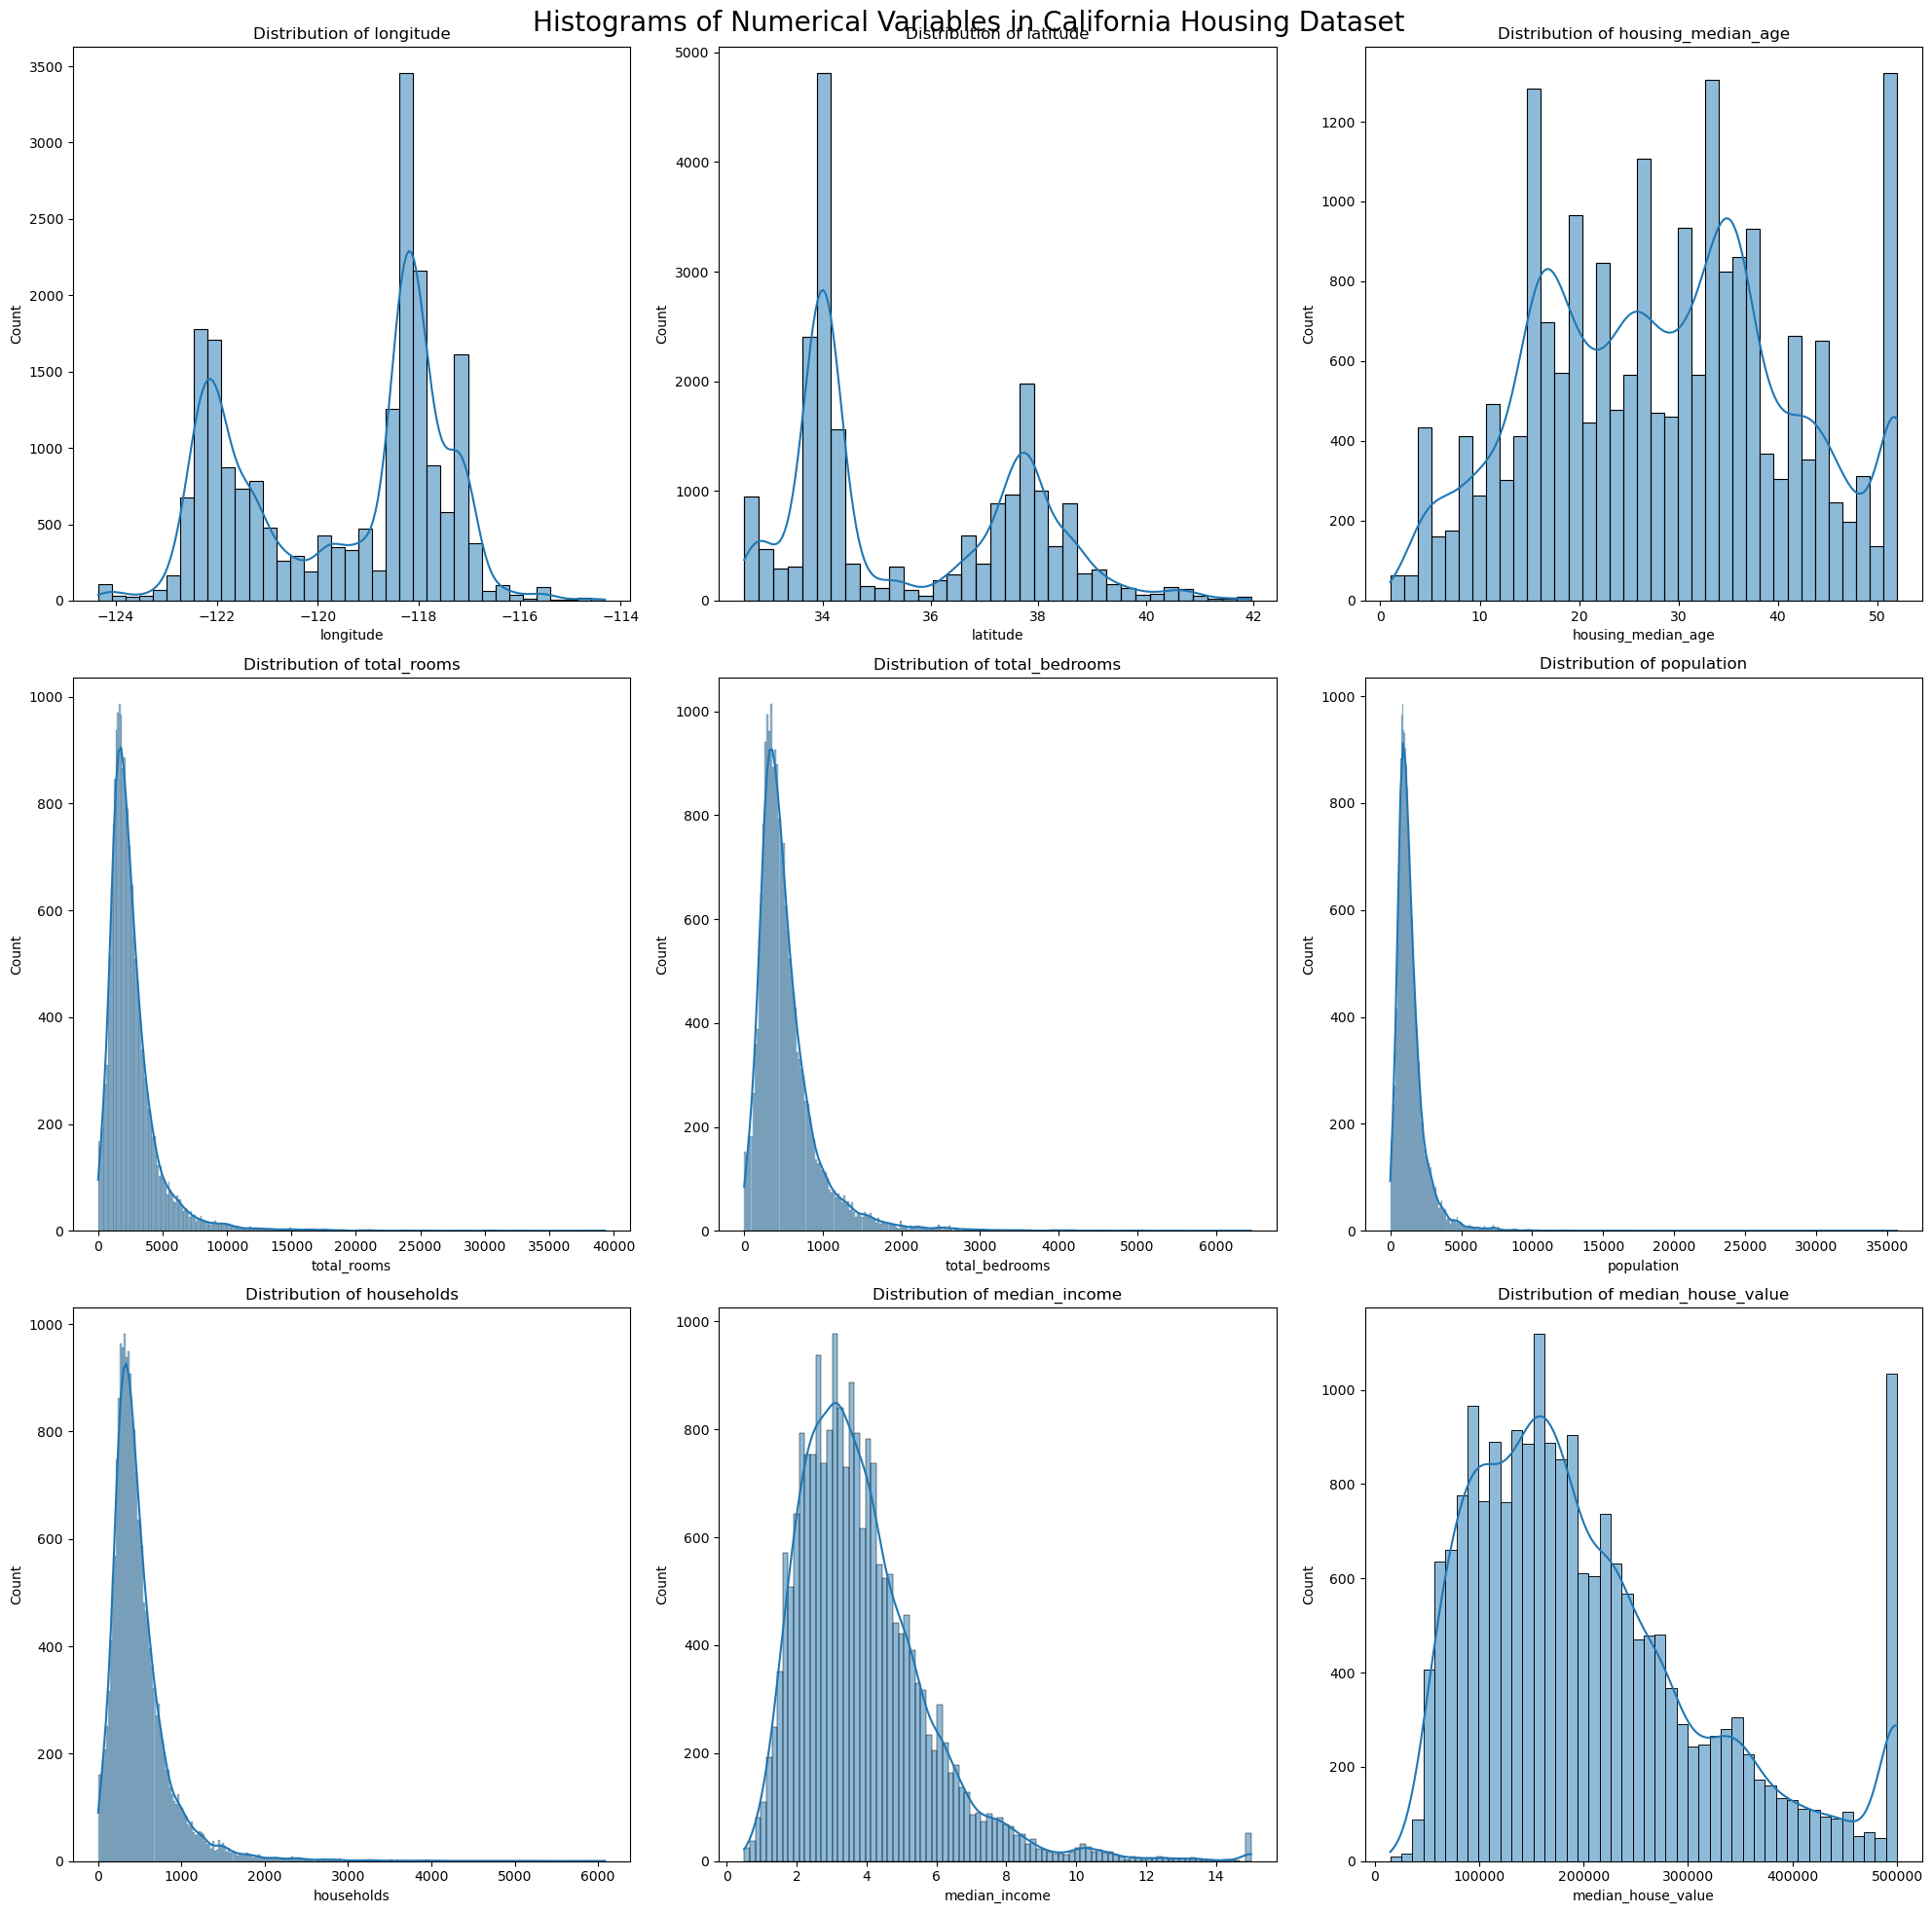

In [11]:
# Identify numerical variables
numerical_vars = data.select_dtypes(include=['int64', 'float64']).columns

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Histograms of Numerical Variables in California Housing Dataset', fontsize=20)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create histograms
for i, var in enumerate(numerical_vars):
    sns.histplot(data=data, x=var, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

# Remove any unused subplots
for i in range(len(numerical_vars), len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

- The distributions are mixed. `housing_median_age` is approaching a uniform distribution. 
- The other numeric ones are skewed to the right. 
- We'll want to think about if/how we scale these values before building any models. 

Let's also look at the box plots to get a better idea of the outliers.

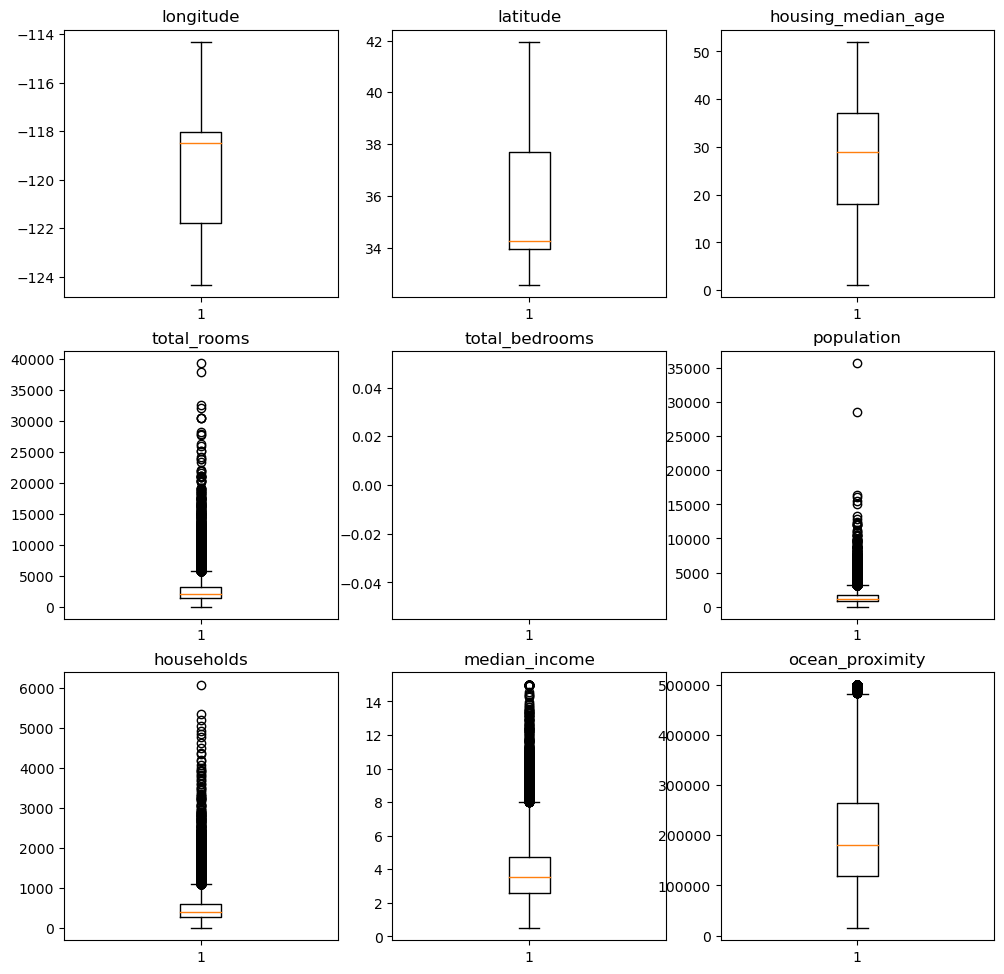

In [12]:
# Box plots, which won't include ocean proximity
vert_plots = 3
hor_plots = data.shape[1] // vert_plots

if data.shape[1] % hor_plots > 0:
    hor_plots = data.shape[1] // vert_plots + 1

plt.figure(figsize=(12,16))
plt.subplots_adjust(hspace=0.2)

col_idx = 0

for vert_plot in range(vert_plots):
    for hor_plot in range(hor_plots):
        if col_idx >= len(cols):
            continue
        col = cols[col_idx]
        
        if col != 'ocean_proximity':
            plt.subplot(hor_plots,vert_plots,col_idx+1)
            try:
                plt.boxplot(data[col])
            except:
                pass
        ax = plt.gca()
        ax.set_title(col)
        col_idx += 1

We are missing a box plot for total_bedrooms. This may be due to missing data; we'll check:

#### Missing Value

In [13]:
print('Total number of missing values:\n', data.isnull().sum())

Total number of missing values:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


### Multicollinearity

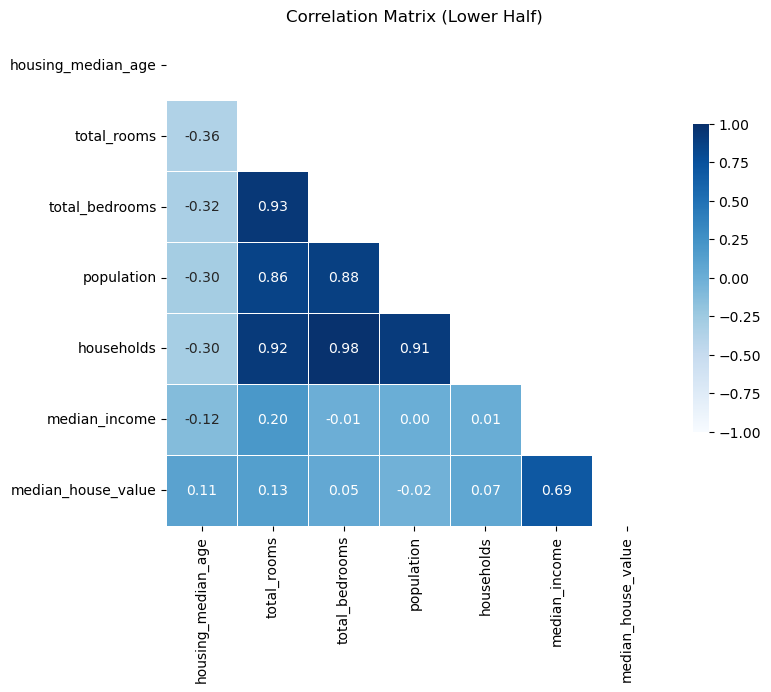

In [14]:
num_data = data.select_dtypes(include='float64')
num_data.drop(['latitude', 'longitude'], axis=1, inplace=True)

corr_matrix = num_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='Blues', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add a title
plt.title('Correlation Matrix (Lower Half)')

# Show the plot
plt.show()

<Figure size 800x800 with 0 Axes>

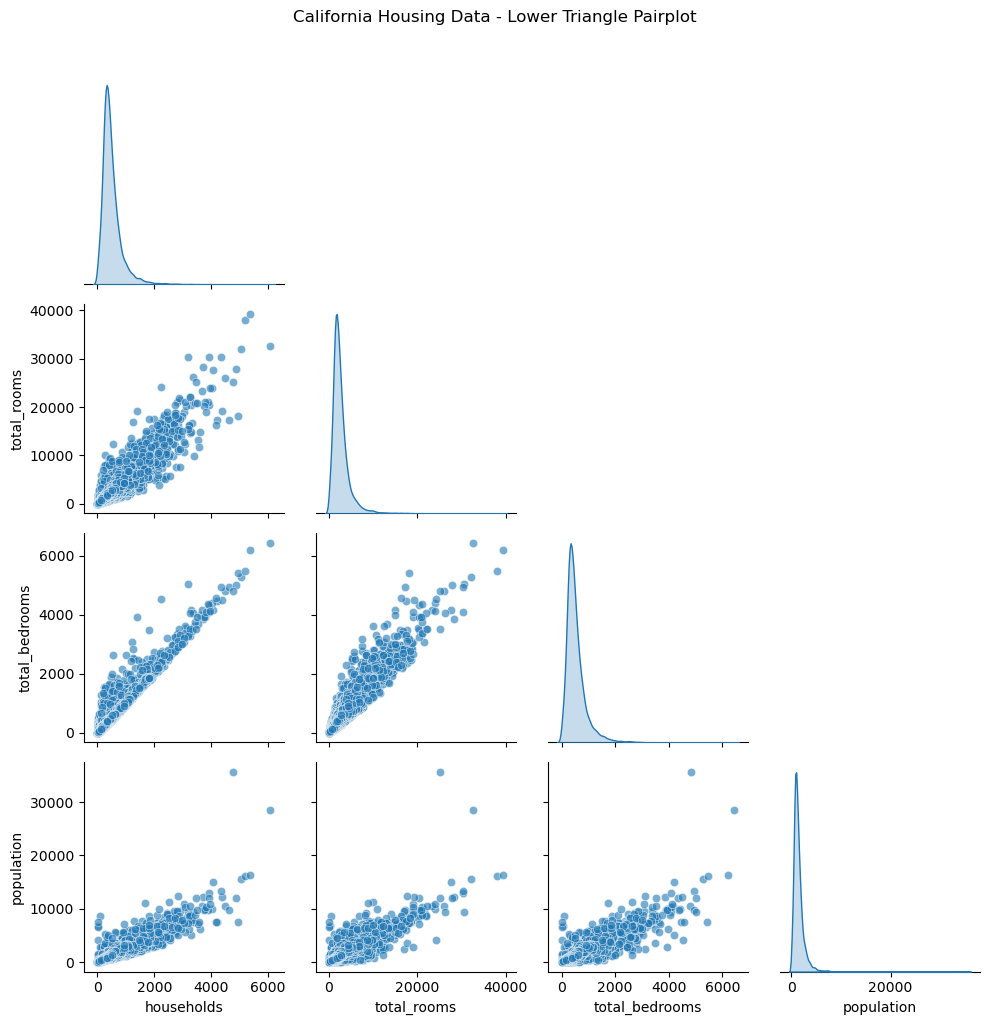

In [15]:
# sns.pairplot(data=num_data[['households','total_rooms','total_bedrooms','population']])
# plt.show()

# Create the pairplot
plt.figure(figsize=(8, 8))
sns.pairplot(num_data[['households','total_rooms','total_bedrooms','population']], 
             corner=True,  # This shows only the lower triangle
             diag_kind="kde",  # Use KDE plots on the diagonal
             plot_kws={"alpha": 0.6})  # Set transparency for better visibility

plt.suptitle("California Housing Data - Lower Triangle Pairplot", y=1.02)
plt.tight_layout()
plt.show()

In [16]:
# Set the threshold
threshold = 0.9

# Find index pairs of highly correlated features
high_corr_var = np.where(np.abs(corr_matrix) > threshold)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y]

# Remove duplicate pairs (since correlation matrix is symmetric)
high_corr_pairs = list(set(tuple(sorted(pair)) for pair in high_corr_pairs))

# Display highly correlated pairs
print("Highly Correlated Pairs:", high_corr_pairs)

Highly Correlated Pairs: [('households', 'total_bedrooms'), ('households', 'total_rooms'), ('households', 'population'), ('total_bedrooms', 'total_rooms')]


In [17]:
# Create a set to hold columns to drop
columns_to_drop = set()

for col1, col2 in high_corr_pairs:
    # Add one of the columns to the set
    columns_to_drop.add(col2)

# Drop the columns
# df_model = df_model.drop(columns=columns_to_drop)

# Display the reduced DataFrame
print("Columns dropped:", columns_to_drop)
# print("Reduced DataFrame:\n", df_reduced)

Columns dropped: {'population', 'total_rooms', 'total_bedrooms'}


## Modeling<a id='modeling'></a>
### Data Preparation

In [18]:
# Split features and target
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# # Define a function to create additional features
# def add_features(X):
#     if isinstance(X, np.ndarray):
#         X = pd.DataFrame(X, columns=numerical_features + preprocessor.transformers_[1][1].get_feature_names_out().tolist())
    
#     X = X.copy()  # Avoid SettingWithCopyWarning
#     X["rooms_per_household"] = X["total_rooms"] / X["households"]
#     X["bedrooms_per_room"] = X["total_bedrooms"] / X["total_rooms"]
#     X["population_per_household"] = X["population"] / X["households"]
#     return X

In [20]:
# Target Variable
sTargetFeature = 'median_house_value'

# Define the preprocessing steps
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

In [21]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', StandardScaler())  # Standardize the numerical features
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical features
])

# Combine the numeric and categorical transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Create the full pipeline with a classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
#     ('feature_adder', FunctionTransformer(add_features, validate=False)),
    ('regressor', GradientBoostingRegressor()) #This is a placeholder, will be replaced during cross validation
])

model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('regressor', GradientBoostingRegressor())])

### Cross Validation

In [22]:
# Define the parameter grid
param_grid = [
#     {
#         'regressor': [LinearRegression()],
#     },
#     {
#         'regressor': [Ridge()],
#         #'regressor__alpha': [0.1, 1.0, 10.0]  # Ridge-specific hyperparameter
#     },
    {
        'regressor': [RandomForestRegressor()],
        #'regressor__n_estimators': [50, 100],
        #'regressor__max_depth': [None, 10, 20]  # RandomForest-specific hyperparameters
    },
    {
        'regressor': [GradientBoostingRegressor()],
        #'regressor__n_estimators': [50, 100],
        #'regressor__max_depth': [None, 10, 20]  # RandomForest-specific hyperparameters
    }    
]

# Use GridSearchCV to find the best algorithm and hyperparameters
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')


# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best model and hyperparameters
print("Best model:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)

Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(step

### Best Model

In [23]:
# Create the full pipeline with a classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
#     ('feature_adder', FunctionTransformer(add_features, validate=False)),
    ('regressor', RandomForestRegressor()) #This is a placeholder, will be replaced during cross validation
])

print(model_pipeline)

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model_pipeline.predict(X_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer

### Model Evaluation

In [24]:
r2s  = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2 Score: {r2s:,.2f}')
print(f'Root Mean Squared Error: {rmse:,.2f}')
print(f'Mean Absolute Error: {mae:,.2f}')
print(f'Mean Absolute Percentage Error: {mape:,.2f}')

# Feature Importance
# get_feature_importance(model_pipeline, 'regressor')

R2 Score: 0.82
Root Mean Squared Error: 49,049.05
Mean Absolute Error: 31,765.05
Mean Absolute Percentage Error: 0.18


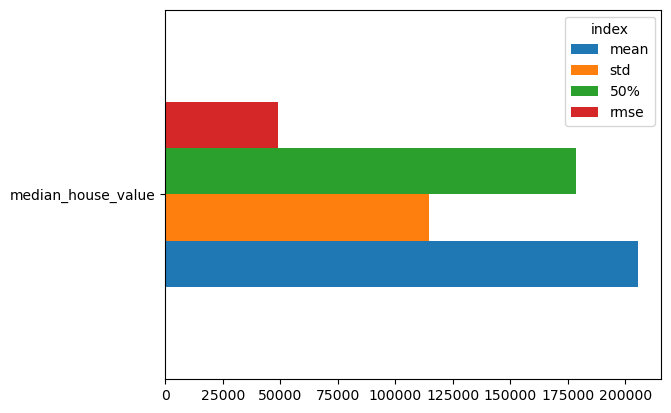

In [25]:
d = y_test.describe().round()[['mean','std','50%']].reset_index()
d.index=d['index']
d.drop('index', axis=1, inplace=True)
d = d.T
d['rmse'] = round(rmse)
d.plot(kind='barh');

### Feature Importance

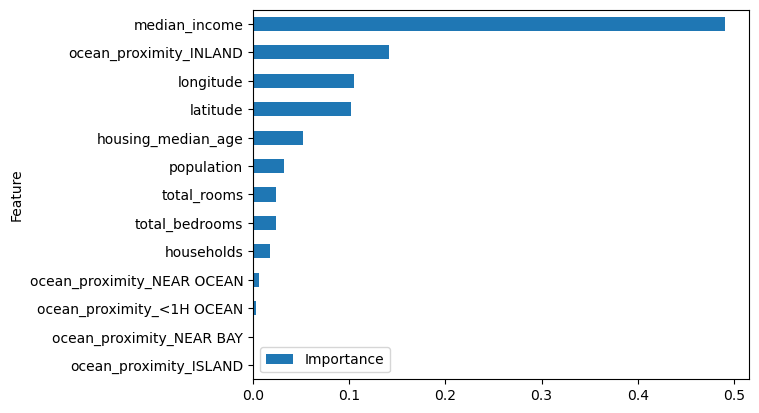

In [27]:
# Get the model from the pipeline
trained_model = model_pipeline.named_steps['regressor']

# Get the feature importances
importances = trained_model.feature_importances_

# Get feature names from the preprocessing step
feature_names = numerical_features + list(model_pipeline.named_steps['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

# new_features = ["rooms_per_household", "bedrooms_per_room", "population_per_household"]

# all_features = feature_names + new_features


# Combine into a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

df_fi = feature_importance_df.tail(20)
# print(df_fi)
df_fi.plot(kind='barh', x='Feature', y='Importance');

## Serialization<a id='serialization'></a>

### Serialization

In [28]:
import pickle

filename = 'regressor.pkl'

In [29]:
with open(filename, 'wb') as file:
    pickle.dump(model_pipeline, file)
    
print(f"Model saved to {filename}")

Model saved to regressor.pkl


### Deserialization

In [30]:
filename = 'regressor.pkl'

with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

print(f"Model loaded from {filename}")

Model loaded from regressor.pkl


### New Predictions

In [31]:
# Build Input JSON string
json_string = '''
[
 {
  "longitude":-119.01,
  "latitude":36.06,
  "housing_median_age":25.0,
  "total_rooms":1505.0,
  "total_bedrooms":null,
  "population":1392.0,
  "households":359.0,
  "median_income":1.6812,
  "ocean_proximity":"INLAND"
 },
 {
  "longitude":-119.46,
  "latitude":35.14,
  "housing_median_age":30.0,
  "total_rooms":2943.0,
  "total_bedrooms":null,
  "population":1565.0,
  "households":584.0,
  "median_income":2.5313,
  "ocean_proximity":"INLAND"
 },
 {
  "longitude":-122.44,
  "latitude":37.8,
  "housing_median_age":52.0,
  "total_rooms":3830.0,
  "total_bedrooms":null,
  "population":1310.0,
  "households":963.0,
  "median_income":3.4801,
  "ocean_proximity":"NEAR BAY"
 },
 {
  "longitude":-118.72,
  "latitude":34.28,
  "housing_median_age":17.0,
  "total_rooms":3051.0,
  "total_bedrooms":null,
  "population":1705.0,
  "households":495.0,
  "median_income":5.7376,
  "ocean_proximity":"<1H OCEAN"
 },
 {
  "longitude":-121.93,
  "latitude":36.62,
  "housing_median_age":34.0,
  "total_rooms":2351.0,
  "total_bedrooms":null,
  "population":1063.0,
  "households":428.0,
  "median_income":3.725,
  "ocean_proximity":"NEAR OCEAN"
 }
]
'''

In [32]:
# Convert JSON string to input DataFrame
df_input = pd.read_json(json_string)
df_input

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-119.01,36.06,25,1505,NaN,1392,359,1.6812,INLAND
1,-119.46,35.14,30,2943,NaN,1565,584,2.5313,INLAND
2,-122.44,37.80,52,3830,NaN,1310,963,3.4801,NEAR BAY
3,-118.72,34.28,17,3051,NaN,1705,495,5.7376,<1H OCEAN
4,-121.93,36.62,34,2351,NaN,1063,428,3.7250,NEAR OCEAN


In [33]:
# Predicted Price
new_predictions = model_pipeline.predict(df_input).round()
print(new_predictions)

[ 49402.  71328. 466662. 243079. 255564.]


### Improvements
- Outliers treatment
- Drop correlated features from pipeline
- Hyperparameter tuning